In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress 
import numpy as np
import math

In [79]:
def GetNumberOfFiles(wavelength,folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if wavelength in filename:
            count += 1
    print(f"Number of files in the folder with {wavelength} in their name: {count}")
    return count


In [80]:
def Process(folder_path,wavelength):   
    nfile = GetNumberOfFiles(wavelength,folder_path)
    Tfull= pd.DataFrame()
    Tpedestalfull= pd.DataFrame()
    outputpath =  f'{folder_path}/plots'
    slopes = [] 
    intercepts= []
    rCoes = []
    stderr = []
    intercepts_stderr = []
    if not os.path.exists(outputpath):
        os.makedirs(outputpath)
        print(f"Directory '{outputpath}' created.")
    else:
        print(f"Directory '{outputpath}' already exists.")

    if wavelength == '532':
        # Rename DataFrame columns
        strg_L = 'Laser Current (mA)'
        temp = '20'
    elif wavelength == '1064':
        strg_L = 'Laser Power (mW)'
        temp = '25'

    for i in range(1, nfile+1):
        filename = f'{folder_path}/Laser_{wavelength}_Step_50_Temp_{temp}_PM_MM_{i}.txt'
        T = pd.read_csv(filename,delimiter ='\t',header=None)
        T.columns = ['date', 'time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']


        # Create a new DataFrame by copying the first row of the original DataFrame
        Tpedestal=T.head(1).copy()
        # Remove the first row from T that corresponds to the pedestal
        T = T.iloc[1:]
        
        # Now concatenate it to the previous pandas frame
        Tfull = pd.concat([Tfull, T])
        Tpedestalfull = pd.concat([Tpedestalfull, Tpedestal])
        # Create separate figures for each plot
        fig = plt.figure(i)
        plt.errorbar(T['L'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel(strg_L)
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.tight_layout()
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_G_{i}_L_PM.png',dpi=199)  # Display the current figure
        plt.close(fig)

        fig = plt.figure(i + 1)
        plt.errorbar(T['L'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean ref PD (V)')
        plt.xlabel(strg_L)
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.tight_layout()
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_{i}_L_PD.png',dpi=199)  # Display the current figure
        plt.close(fig)

        #Linear fit 
        res = linregress(T['meanRefPD'], T['meanPM'])
        slope = res.slope 
        intercept = res.intercept
        r=res.rvalue
        se = res.stderr
        intercept_stderr = res.intercept_stderr

        slopes.append(slope)
        intercepts.append(intercept)
        rCoes.append(r)
        stderr.append(se)
        intercepts_stderr.append(intercept_stderr)

        fig = plt.figure(i + 2)
        plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.plot(T['meanRefPD'], intercept + slope*T['meanRefPD'], 'r', label='fitted line')
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Mean ref PD (V)')
        plt.grid()
        plt.title(f'Plot G {i}')
        plt.tight_layout()
        plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_{i}_PD_PM.png',dpi=199)  # Display the current figure
        plt.close(fig)

        plt.figure(101)
        plt.grid()
        plt.errorbar(T['L'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel(strg_L)
        plt.title(f'all datasets')
        
        
        plt.figure(102)
        plt.grid()
        plt.errorbar(T['L'], T['meanRefPD'], yerr=T['stdRefPD'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean ref PD (V)')
        plt.xlabel(strg_L)
        plt.title(f'all datasets')
        

        plt.figure(103)
        plt.grid()
        plt.errorbar(T['meanRefPD'], T['meanPM'], yerr=T['stdPM'], fmt='.', markersize=10, linewidth=1)
        plt.ylabel('Mean Optical Power (W)')
        plt.xlabel('Mean ref PD (V)')
        plt.title(f'all datasets')
    SignalAnalysis(Tfull,nfile,slopes,stderr,intercepts,intercepts_stderr,rCoes,res,outputpath,wavelength)
    PedestalAnalysis(Tpedestalfull['meanRefPD'],Tpedestalfull['stdRefPD'],'Optical Power (W)',outputpath, wavelength)
    PedestalAnalysis(Tpedestalfull['meanPM'],Tpedestalfull['stdPM'],'ref PD (V)',outputpath, wavelength)
    return Tfull, Tpedestalfull
 

In [97]:
def SignalAnalysis(Tfull,nfile,slopes,stderr,intercepts,intercepts_stderr,rCoes,res,outputpath,wavelength):  
     
    x=Tfull['meanRefPD']
    y=Tfull['meanPM']

    res = linregress(x, y)
    datasets= nfile
    slopes_micro=[i * 1e6 for i in slopes]
    stderr_micro=[i * 1e6 for i in stderr]

    intercepts_micro=[i * 1e6 for i in intercepts]
    intercepts_stderr_micro=[i * 1e6 for i in intercepts_stderr]

    print(f'Calibration coefficient found as linear adjustment of all the dataset = {res.slope*1e6} +/- {res.stderr*1e6} in $\mu$W/V')
    print(f'Calibration coefficient found as mean of the linear adjustment of each dataset = {np.mean(slopes_micro)} +/- {np.std(slopes_micro)} in $\mu$W/V')
   
    #Errors in percentage 
    relativeError = round((np.mean(slopes)-res.slope)/np.mean(slopes)*100,3)
    dispersion = round((np.max(slopes)-np.min(slopes))/np.max(slopes)*100,3)
    print('relativeError = ',relativeError,'% and dispersion = ',dispersion,'%')
    
    # Customize the plot
    fig = plt.figure(100)
    plt.errorbar(range(len(slopes)), slopes_micro,stderr_micro, fmt='.', markersize=10, linewidth=1)
    plt.title(f'Calibration at {wavelength} nm, relative error = {relativeError}, dispersion = {dispersion}')
    plt.xlabel('Dataset Index')
    plt.ylabel('Calibration coefficient ($\mu$W/V)')
    plt.xticks(range(datasets), [f'D {i+1}' for i in range(10)])  # Label the x-axis with dataset identifiers
    #plt.legend()
    plt.axhline(y=res.slope*1e6, color='red', linestyle='--', label='Horizontal Line at y=m_all')
    plt.axhline(y=np.mean(slopes_micro), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
    plt.fill_between(range(-1,len(slopes)+1), (res.slope-res.stderr)*1e6, (res.slope+res.stderr)*1e6, color='red', alpha=0.3, label='Shaded Region')
    plt.fill_between(range(-1,len(slopes)+1), (np.mean(slopes_micro)-np.std(slopes_micro)), (np.mean(slopes_micro)+np.std(slopes_micro)), color='purple', alpha=0.2, label='Shaded Region')
    #plt.ylim([0.00064*1e6, 0.000665*1e6])
    plt.xlim([-1,10])
    plt.grid()
    # Show the plot
    #plt.show()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_GAll_Cal_coeff.png',dpi=199)

    # Customize the plot
    fig = plt.figure(104)
    plt.errorbar(range(len(intercepts)), intercepts_micro,intercepts_stderr_micro, fmt='.', markersize=10, linewidth=1)
    plt.title(f'Offset for Different Datasets at {wavelength}')
    plt.xlabel('Dataset Index')
    plt.ylabel('Intercepts ($\mu$W)')
    plt.xticks(range(datasets), [f'D {i+1}' for i in range(10)])  # Label the x-axis with dataset identifiers
    #plt.legend()
    plt.axhline(y=res.intercept*1e6, color='red', linestyle='--', label='Horizontal Line at y=m_all')
    plt.axhline(y=np.mean(intercepts_micro), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
    plt.fill_between(range(-1,len(intercepts)+1), (res.intercept-res.intercept_stderr)*1e6, (res.intercept+res.intercept_stderr)*1e6, color='red', alpha=0.3, label='Shaded Region')
    plt.fill_between(range(-1,len(intercepts)+1), (np.mean(intercepts_micro)-np.std(intercepts_micro)), (np.mean(intercepts_micro)+np.std(intercepts_micro)), color='purple', alpha=0.2, label='Shaded Region')
    #plt.ylim([0.00064*1e6, 0.000665*1e6])
    plt.xlim([-1,10])
    plt.grid()
    # Show the plot
    #plt.show()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}_Step_50_PM_MM_All_Intercepts.png',dpi=199)

    plt.figure(101)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_PM_MM_all_trend_LPower_PM.png',dpi=199)

    plt.figure(102)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_PM_MM_all_trend_LPower_PD.png',dpi=199)

    plt.figure(103)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Laser_{wavelength}__Step_50_PM_MM_all_trend_PD_PM.png',dpi=199)

    return Tfull, slopes, intercepts, rCoes,stderr, res    

In [98]:
def PedestalAnalysis(mean, std, name, outputpath, wavelength):
    samples = len(mean)
    fig = plt.figure(1103)
    # Mean and std deviation of the PM 
    plt.errorbar(range(samples), mean, yerr=std, fmt='.', markersize=10, linewidth=1)
    plt.axhline(y=np.mean(mean), color='purple', linestyle='--', label='Horizontal Line at y=m_av')
    plt.fill_between(range(samples), np.mean(mean)-np.std(mean), np.mean(mean)+np.std(mean), color='red', alpha=0.3, label='Shaded Region')

    plt.ylabel(f'Pedestal of {name}')
    plt.xlabel('Test number [#]')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{outputpath}/Pedestal_{wavelength}_{name}.png',dpi=199)  # Display the current figure
    plt.close(fig)
    print(f'The pedestal of the values {name} are: Mean= {np.mean(mean)} std= {np.std(mean)}')


Number of files in the folder with 532 in their name: 10
Directory '../data/532nm/plots' already exists.
Calibration coefficient found as mean of the linear adjustment of each dataset = 652.1403636847348 +/- 0.6003751318023874 in $\mu$W/V
Calibration coefficient found as linear adjustment of all the dataset = 650.4678468469658 +/- 6.4151316660381195 in $\mu$W/V
relativeError =  -0.257 % and dispersion =  3.102 %
The pedestal of the values Optical Power (W) are: Mean= 5.6e-07 std= 3.52703841770968e-07
The pedestal of the values ref PD (V) are: Mean= 0.0 std= 0.0


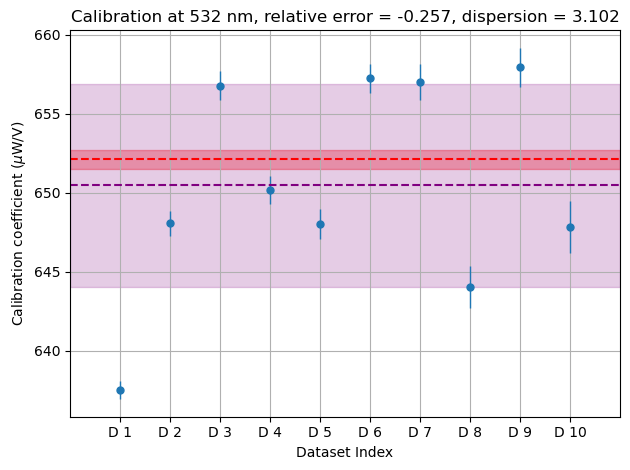

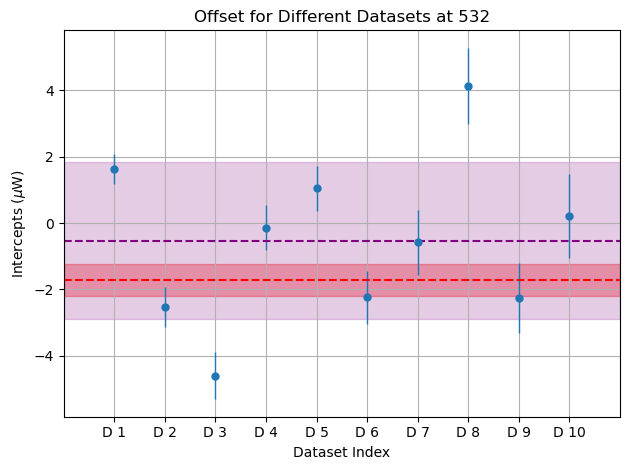

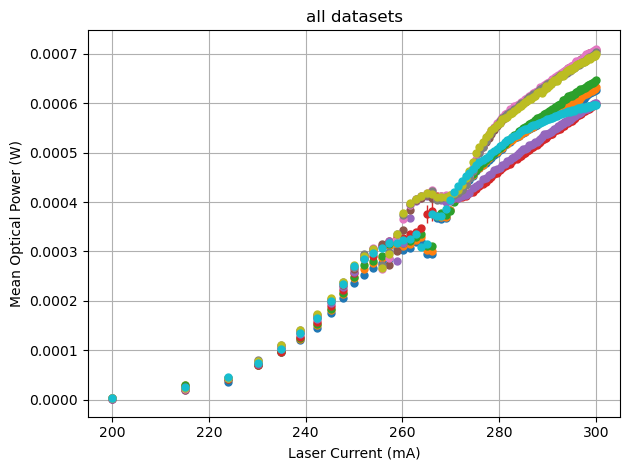

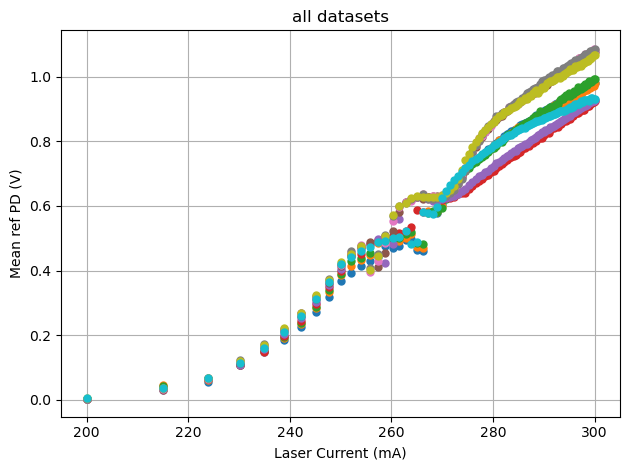

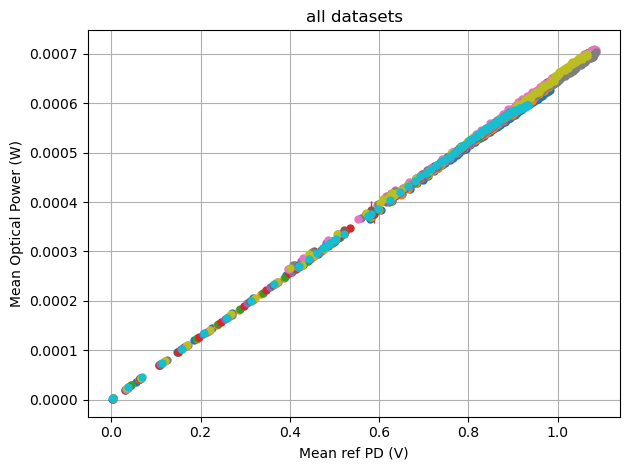

In [100]:
#Obtain a deep look of the data
#Tfull, Tpedestal = Process('../data/1064nm','1064')
Tfull, Tpedestal = Process('../data/532nm','532')


In [102]:
Tpedestal

,date,time,L,meanPM,stdPM,meanRefPD,stdRefPD,Temp,RH,samples
0,12/3/2023,18:46:40,0.0,0.0,0.0,1.100000e-06,2.000000e-07,22.8,32.0,100
0,12/3/2023,20:47:40,0.0,0.0,0.0,1.000000e-06,2.000000e-07,22.5,32.0,100
0,12/3/2023,22:48:43,0.0,0.0,0.0,1.100000e-06,2.000000e-07,22.2,32.0,100
0,12/4/2023,0:49:47 A,0.0,0.0,0.0,6.000000e-07,1.000000e-07,21.9,32.0,100
0,12/4/2023,2:50:50 A,0.0,0.0,0.0,3.000000e-07,2.000000e-07,21.5,32.0,100
0,12/4/2023,4:51:53 A,0.0,0.0,0.0,4.000000e-07,2.000000e-07,21.2,32.0,100
0,12/4/2023,6:52:57 A,0.0,0.0,0.0,3.000000e-07,2.000000e-07,21.0,32.0,100
0,12/4/2023,8:54:00 A,0.0,0.0,0.0,3.000000e-07,1.000000e-07,20.8,32.0,100
0,12/4/2023,10:55:05,0.0,0.0,0.0,1.000000e-07,2.000000e-07,21.0,32.0,100
0,12/4/2023,12:56:07,0.0,0.0,0.0,4.000000e-07,2.000000e-07,21.6,31.0,100
